In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def clean_rows(df, indexes):
    """
    Removes from df all rows with the specified indexes
    :param pd.DataFrame or pd.Series df:
    :param list-of-str indexes
    :return pd.DataFrame or pd.Series:
    """
    for idx in indexes:
        df = df[df.index != idx]
    return df

## Load and Massage the Data

In [4]:
df = pd.read_csv("2015_trip_data.csv")

#create the date columns
df['starttime'] = pd.DatetimeIndex(df['starttime'])
df['stoptime'] = pd.DatetimeIndex(df['stoptime'])

df['startdayofweek'] = pd.DatetimeIndex(df['starttime']).dayofweek
df['stopdayofweek'] = pd.DatetimeIndex(df['stoptime']).dayofweek
df['date_start'] = pd.DatetimeIndex(df['starttime']).date
df['date_stop'] = pd.DatetimeIndex(df['stoptime']).date



In [5]:
#groupby
groupby_week_from = df.groupby(['from_station_id', 'startdayofweek']).size()
groupby_week_to = df.groupby(['to_station_id','stopdayofweek']).size()


In [6]:

#calculate how many days there were in each year
number_days_from = df.groupby(['startdayofweek','date_start']).size().reset_index()
number_days_from = number_days_from.groupby(['startdayofweek'])['date_start'].count()
number_days_to = df.groupby(['stopdayofweek','date_stop']).size().reset_index()
number_days_to = number_days_to.groupby(['stopdayofweek'])['date_stop'].count()

avg_station_from = groupby_week_from/number_days_from
avg_station_to = groupby_week_to/number_days_to

avg_diff_from_to = avg_station_to.unstack() - avg_station_from.unstack()

## Make a single variable bar plot of the differences

In [7]:
def plot_bar1(df, day, opts):
    """
    :param df.DataFrame df
    :param dict opts: key is plot attribute
    :param day: day (column) to plot
    """
    
    n_groups = len(df.index)
    index = np.arange(n_groups)
    rects1 = plt.bar(index, df[day])
    
    if 'xlabel' in opts:
        plt.xlabel(opts['xlabel'])
    if 'ylabel' in opts:
        plt.ylabel(opts['ylabel'])
    if 'xticks' in opts and opts['xticks']:
        plt.xticks(index, df.index)
        _, labels = plt.xticks()
        plt.setp(labels, rotation = 90)
    else:
        labels = ['' for x in df.index]
        plt.xticks(index, labels)
    if 'ylim' in opts:
        plt.ylim(opts['ylim'])
    if 'title' in opts:
        plt.title(opts['title'])
        
    plt.axhline(y=0.0, color = 'k', linestyle='-')

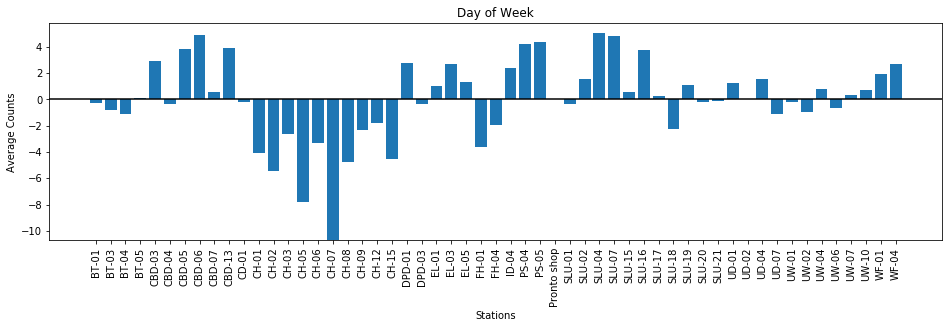

In [8]:
fig = plt.figure(figsize=(16,4))
opts = {'xlabel': 'Stations', 'ylabel': 'Average Counts', 'title': 'Day of Week', 'xticks': True}
plot_bar1(avg_diff_from_to, 0, opts)

## Make a function that makes subplots calling my bar plot function

In [9]:
def plot_barN(df, variables, opts):
    """
    Does a bar plot for a single column.
    :param pd.DataFrame df:
    :param list-of-str columns: names of the column to plot
    :param dict opts: key is plot attribute
    """
    
    num_columns = len(variables)
    #if r*2 < (num_columns+1):
    #    print('Not enough rows, please increase the number to fit all plots.')
    #    return None
    #else:
    #    pass
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    opts['title'] = days
    local_opts = dict(opts)
    idx = 0
    local_opts['title'] = days
    for var in variables:
        idx += 1
        local_opts['xticks'] = False
        local_opts['xlabel'] = ''
        local_opts['title'] = opts['title'][var]
        if idx == num_columns: #or idx == (num_columns-1):
            local_opts['xticks'] = True
            local_opts['xlabel'] = opts['xlabel']
        #fig = plt.figure(figsize = (4,4))
        plt.subplot(num_columns, 1, idx)
        plot_bar1(df, var, local_opts)

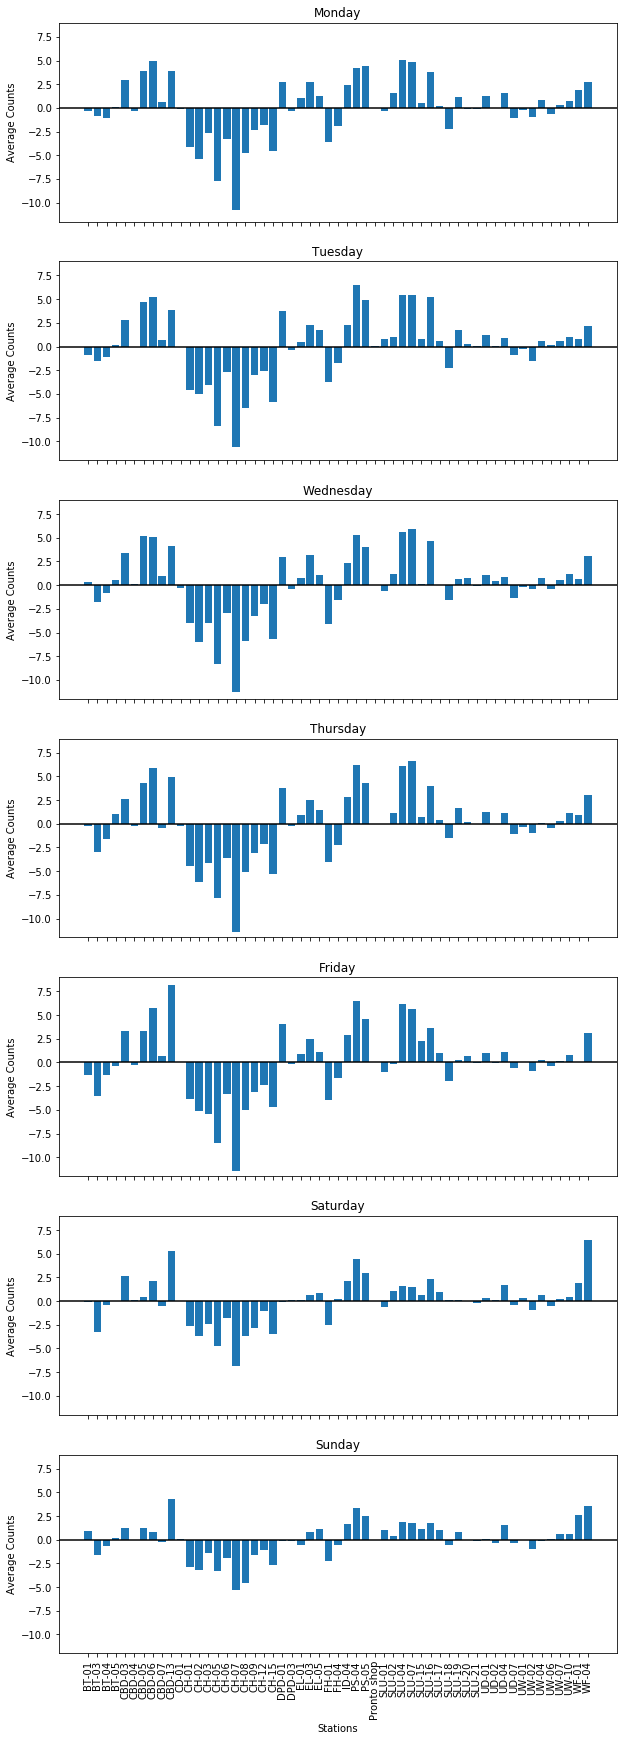

In [10]:
fig = plt.figure(figsize=(10,30))
opts = {'xlabel': 'Stations', 'ylabel': 'Average Counts', 'xticks': True, 'ylim': [round(avg_diff_from_to.min() - 1).min(), round(avg_diff_from_to.max() + 1).max()]}
plot_barN(avg_diff_from_to, range(7), opts)

##### A negative value means that more people left that station than went to that station. This means that there was potentially a lack of bikes at this station at the end of the day. A positive number means the opposite. 

##### An interesting finding is that on average for each day of the week there were more bikes that left stations starting with CH. I assume this would be capital hill. Nearly every other station has more bikes arriving than leaving. This means that capital hill is the most popular place that rents bikes, and each day enough bikes should be shuttled from other locations back to these stations. This way all customers will have a bike to rent, and there could be some optimization to make sure that the company doesn't spend more on bikes than it needs to. 